In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [4]:
IMG_SIZE = 224
batch_size = 64

_, breed_info = tfds.load(
    'stanford_dogs', with_info=True, as_supervised=True
)

_, cats_dogs_info = tfds.load(
    'cats_vs_dogs', with_info=True, as_supervised=True
)


print(f'cats_vs_dogs: {cats_dogs_info.features["label"].num_classes}')
print(f'dog breeds: {breed_info.features["label"].num_classes}')


cats_vs_dogs: 2
dog breeds: 120


In [5]:
# build model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
cats_dogs_model = build_model(num_classes=2)

In [6]:
tf.__version__


'2.3.0'

In [7]:
dogs_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

cats_dogs_model.load_weights('../tf_models/colab/cats_dogs_best_colab1.h5')

dogs_model = tf.keras.models.load_model('../tf_models/colab/best_colab1_fine.h5', compile=False)
dogs_model.compile(
        optimizer=dogs_optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [9]:
dogs_model.summary()

]               
                                                                 block5a_project_bn[0][0]         
__________________________________________________________________________________________________
block5c_expand_conv (Conv2D)    (None, 14, 14, 672)  75264       block5b_add[0][0]                
__________________________________________________________________________________________________
block5c_expand_bn (BatchNormali (None, 14, 14, 672)  2688        block5c_expand_conv[0][0]        
__________________________________________________________________________________________________
block5c_expand_activation (Acti (None, 14, 14, 672)  0           block5c_expand_bn[0][0]          
__________________________________________________________________________________________________
block5c_dwconv (DepthwiseConv2D (None, 14, 14, 672)  16800       block5c_expand_activation[0][0]  
____________________________________________________________________________________________

japanese_spaniel: 0.0055696661584079266
chihuahua: 0.9944303631782532


'chihuahua'

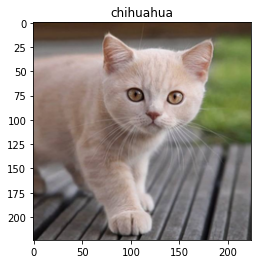

In [13]:
from utils import predict_image

file = '../data/test_data/gato3.png'

predict_image(file, dogs_model, breed_info)


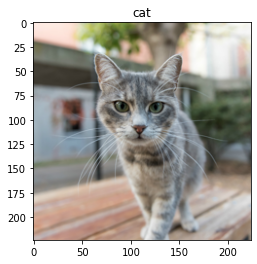

In [53]:
predict_image(file, cats_dogs_model, cats_dogs_info)